In [1]:
### KNN exercise on Amazon Fine Food Reviews Data set 

# Data source - URL https://www.kaggle.com/snap/amazon-fine-food-reviews

## Data Contains reviews of fine food from Amazon. 
## It includes information about product, user, ratings, text review. 



In [2]:
## Objective: 
    # 1. Apply KNN on Amazon FFR using BOW, Word2Vec, TFIDF, AvgWord2Vec
    # 2. Implement using KD-Tree and Brute KNN
    # 3. Metrics: Accuracy, precision, recall, f1-score etc. Confusion matrix

## Predict the Polarity of a given review

In [3]:
## Columns 
    # 1.Id
    # 2.ProductId - unique identifier for the product
    # 3.UserId - unqiue identifier for the user
    # 4.ProfileName
    # 5.HelpfulnessNumerator - number of users who found the review helpful
    # 6.HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    # 7.Score - rating between 1 and 5
    # 8.Time - timestamp for the review
    # 9.Summary - brief summary of the review
    # 10.Text - text of the review

In [4]:
#######################################################################

# Lets start with imports 


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from time import time
import random
import gensim
import warnings


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline 

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
## Load from SQL file (sqlite)

con = sql.connect('final.sqlite') ## This file obtained after text preprocessing in previous chapter 

df = pd.read_sql_query(''' SELECT * from Reviews''', con)

df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b''
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b''
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b''
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b''
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b''


In [6]:

print (df.shape)
print (df['Score'].size)
df.describe()

(364171, 13)
364171


,index,Id,HelpfulnessNumerator,HelpfulnessDenominator,Time
count,364171.000000,364171.000000,364171.000000,364171.000000,3.641710e+05
mean,241825.377603,261814.561014,1.739021,2.186841,1.296135e+09
std,154519.869452,166958.768333,6.723921,7.348482,4.864772e+07
min,0.000000,1.000000,0.000000,0.000000,9.393408e+08
25%,104427.500000,113379.500000,0.000000,0.000000,1.270858e+09
50%,230033.000000,249445.000000,0.000000,1.000000,1.311379e+09
75%,376763.500000,407408.500000,2.000000,2.000000,1.332893e+09
max,525813.000000,568454.000000,866.000000,878.000000,1.351210e+09


In [7]:
### Convert Score back to 1 or 0 

def polarity(x):
    if x == 'Positive':
        return 1
    return 0

df['Score'] = df['Score'].map(polarity)

df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b''
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b''
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b''
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b''
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b''


In [8]:
###### Lets consider only few samples due to computational limitation

n_samples = 20000
df_sample = df.sample(n_samples)

### Sort them based on Time series (Time Series split)

df_sample.sort_values('Time', inplace=True)
df_sample.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
117924,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...,b''
117901,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...,b''
169281,212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...,b''
117334,138001,149770,B00004S1C5,A1KXONFPU2XQ5K,Stephanie Manley,8,8,1,965779200,Very easy to use,This are so much easier to use than the Wilson...,b'much easier use wilson past color color vibr...,b''
117351,138018,149790,B00004S1C6,A1IU7S4HCK1XK0,Joanna Daneman,25,27,1,982800000,Make your own Martha Stewart style cakes and c...,I don't know why anyone would ever use those l...,b'dont know anyon would ever use littl liquid ...,b''


In [9]:
#### Lets Save data to disk

import pickle 

def savetofile(obj, filename):
    ''' Save to Local Disk'''
    
    pickle.dump(obj, open(filename+".p","wb"))

def openfromfile(filename):
    ''' Read data from pickled file'''
    
    temp = pickle.load(open(filename+".p","rb"))
    return temp


## Save to Local Machine 
savetofile(df_sample, "sample_20000_knn")

df_sample = openfromfile('sample_20000_knn')

In [10]:
################################################# 
## Lets start with BOW - Bag of Words 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

## Split into train, test set using model_selection.train_test_split (previously it was cross_validation

X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values, 
                                                    df_sample['Score'].values, 
                                                    test_size=0.3, 
                                                    shuffle=False)

## Unigram 
uni_gram = CountVectorizer() ## By default it is uni_gram .. 
X_train = uni_gram.fit_transform(X_train)

## Normalize Data 
X_train = preprocessing.normalize(X_train)
print ("Train data size ", X_train.shape)

X_test = uni_gram.transform(X_test)
X_test = preprocessing.normalize(X_test)

print ("Test data size ", X_test.shape)

Train data size  (14000, 23370)
Test data size  (6000, 23370)


In [11]:
### Time Series Split Example 
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=10)

for train, cv in tscv.split(X_train):
    print (X_train[train].shape, X_train[cv].shape)

(1280, 23370) (1272, 23370)
(2552, 23370) (1272, 23370)
(3824, 23370) (1272, 23370)
(5096, 23370) (1272, 23370)
(6368, 23370) (1272, 23370)
(7640, 23370) (1272, 23370)
(8912, 23370) (1272, 23370)
(10184, 23370) (1272, 23370)
(11456, 23370) (1272, 23370)
(12728, 23370) (1272, 23370)


In [12]:
%%time
#################################################################### 
## Finding the best "K" using Forward Chaining Cross validation or Timeseries CV 
from sklearn.neighbors import KNeighborsClassifier

n_splits = 5 ## No.of Splits 
neigh_max = 15 ## Maximum of Neighbors 

tscv = TimeSeriesSplit(n_splits=n_splits)

k_acc = [] ## To store accuracy os different K value
k_acc_median = []

for k in range(1, neigh_max, 2):
    acc_list = [] ## To store accuracy of different CV folds
    
    for train, cv in tscv.split(X_train):
        if (train.size > k):
            knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute', n_jobs=-1)
            knn.fit(X_train[train], y_train[train])
            acc_list.append(knn.score(X_train[cv], y_train[cv]) * 100 )
    if acc_list:
        acc_np_arr = np.array(acc_list)
        
    k_acc.append(acc_np_arr.mean())
    k_acc_median.append(np.median(acc_np_arr))
    print ("Iteration finished ", k)
k_acc = np.array(k_acc)
k_acc_median = np.array(k_acc_median)

Iteration finished  1
Iteration finished  3
Iteration finished  5
Iteration finished  7
Iteration finished  9
Iteration finished  11
Iteration finished  13
Wall time: 5min 39s


In [13]:
savetofile(k_acc,"k_acc_uni_gram")

In [14]:
k_acc_uni_gram = openfromfile("k_acc_uni_gram")
k_acc_uni_gram

array([80.3857694 , 83.56622375, 84.69781397, 84.83497643, 84.96356622,
       84.95499357, 84.82640377])

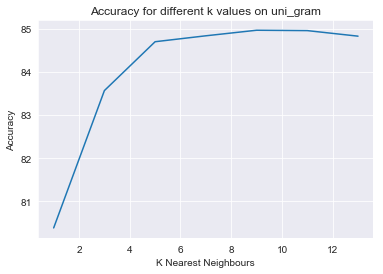

In [15]:
sns.set_style('darkgrid')
plt.plot(np.arange(1,15,2),k_acc_uni_gram)
plt.xlabel("K Nearest Neighbours")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values on uni_gram")
plt.show()

In [16]:
%%time
######################################################################## 

## Using GRID Search and Brute Force Algorithm

from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier(algorithm='brute')

param_grid = {'n_neighbors':np.arange(3, 13, 2)}

tscv = TimeSeriesSplit(n_splits=10)

grid_search = GridSearchCV(knn, param_grid, cv=tscv, verbose=1)

grid_search.fit(X_train, y_train)

print ("Best Parameter : ", grid_search.best_params_)
print ("Best Param Accuracy : ", grid_search.best_score_ * 100)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best Parameter :  {'n_neighbors': 11}
Best Param Accuracy :  85.14150943396226
Wall time: 3min 25s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.4min finished


Accuracy =  84.08333333333333
Precision  0.844375431331953
Recall  0.9892864362239742
F1-Score  0.9111049055198733


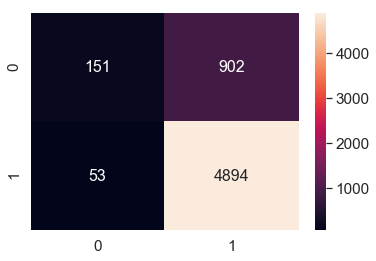

In [17]:
#### Accuracy 

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print ("Accuracy = ", (accuracy_score(y_test, y_pred) * 100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))

df_conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))

sns.set(font_scale=1.4)
sns.heatmap(df_conf_mat, annot=True, annot_kws={'size':16}, fmt='g')

In [18]:
%%time
############ Using KD-Tree Algorithm #####################


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='kd_tree')

param_grid = {'n_neighbors':np.arange(3,13,2)} 

tscv = TimeSeriesSplit(n_splits=10) 
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)

gsv.fit(X_train,y_train)

print("Best Parameter: ",gsv.best_params_)
print("Best Accuracy: ", (gsv.best_score_*100))

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best Parameter:  {'n_neighbors': 11}
Best Accuracy:  85.14150943396226
Wall time: 3min 22s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.4min finished


Accuracy =  84.08333333333333
Precision  0.844375431331953
Recall  0.9892864362239742
F1-Score  0.9111049055198733


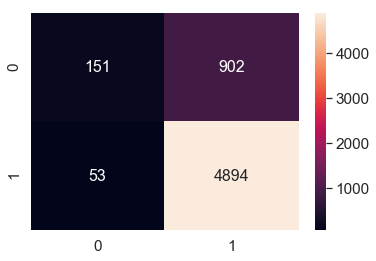

In [19]:
### Accuracy 


from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=gsv.best_params_['n_neighbors'],algorithm='kd_tree')

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)


print ("Accuracy = ", (accuracy_score(y_test, y_pred) * 100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))


df_conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))

sns.set(font_scale=1.4)
sns.heatmap(df_conf_mat, annot=True, annot_kws={'size':16}, fmt='g')

In [20]:
############################################################################### 

## BOW -- Bi-Gram 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values, 
                                                    df_sample['Score'].values, 
                                                    test_size=0.3, shuffle=False)

bi_gram = CountVectorizer(ngram_range=(1, 2))

X_train = bi_gram.fit_transform(X_train)

## Normalize Data 
X_train = preprocessing.normalize(X_train)

print("Train Data Size: ",X_train.shape)

X_test = bi_gram.transform(X_test)

#Normalize Data
X_test = preprocessing.normalize(X_test)

print("Test Data Size: ",X_test.shape)

Train Data Size:  (14000, 316143)
Test Data Size:  (6000, 316143)


In [27]:
%%time
################ Brute Algorithm on Bi-Gram 

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='brute')

param_grid = {'n_neighbors':np.arange(3, 15, 2)}

tscv = TimeSeriesSplit(n_splits=10)

gsv = GridSearchCV(knn, param_grid, cv=tscv, verbose=1)

gsv.fit(X_train, y_train)

print("Best HyperParameter: ", gsv.best_params_)
print("Best Accuracy:  ", (gsv.best_score_*100))

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best HyperParameter:  {'n_neighbors': 7}
Best Accuracy:   85.25157232704402
Wall time: 3min 45s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.7min finished


Accuracy  84.26666666666667
Precision  0.846340197265963
Recall  0.9886800080857086
F1-Score  0.9119895580831624


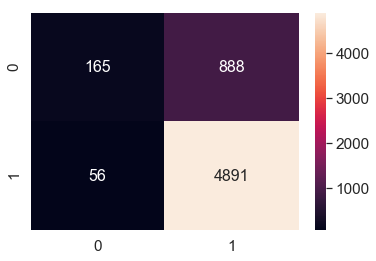

In [22]:
### Accuracy 


from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=gsv.best_params_['n_neighbors'])

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print("Accuracy ", (accuracy_score(y_test, y_pred)*100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))


df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))

sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [23]:
%%time
##### KD-Tree Algo on Bi-Gram 

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='kd_tree')

param_grid = {'n_neighbors':np.arange(3,15,2)}

tscv = TimeSeriesSplit(n_splits=10) 

gsv = GridSearchCV(knn, param_grid , cv=tscv, verbose=1)

gsv.fit(X_train,y_train)

print("Best Parameter ", gsv.best_params_)
print("Best Accuracy ", (gsv.best_score_*100))

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best Parameter  {'n_neighbors': 9}
Best Accuracy  85.44025157232704
Wall time: 4min 3s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.1min finished


Accuracy  84.36666666666667
Precision  0.8478223147666146
Recall  0.9876692945219325
F1-Score  0.9124183006535947


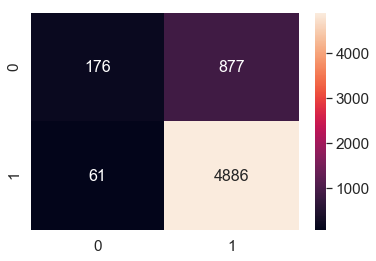

In [24]:
### Accuracy 

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=gsv.best_params_['n_neighbors'],algorithm='kd_tree')

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print("Accuracy ", (accuracy_score(y_test, y_pred)*100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))


df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))

sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [25]:
%%time
#################################################################

### TF-IDF 


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,
                                                    df_sample['Score'].values,
                                                    test_size=0.3,shuffle=False)

tfidf = TfidfVectorizer(ngram_range=(1,2)) 
X_train = tfidf.fit_transform(X_train)

#Normalize Data
X_train = preprocessing.normalize(X_train)

print("Train Data Size: ",X_train.shape)

X_test = tfidf.transform(X_test)

#Normalize Data
X_test = preprocessing.normalize(X_test)

print("Test Data Size: ",X_test.shape)

Train Data Size:  (14000, 316143)
Test Data Size:  (6000, 316143)
Wall time: 3.88 s


In [28]:
%%time

########### Brue Algorithm 


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(algorithm='brute')


param_grid = {'n_neighbors':np.arange(3,15,2)} #params we need to try on classifier

tscv = TimeSeriesSplit(n_splits=10) #For time based splitting

gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)

print("Best Parameter ",gsv.best_params_)
print("Best Accuracy: ", gsv.best_score_*100)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best Parameter  {'n_neighbors': 7}
Best Accuracy:  85.25157232704402
Wall time: 3min 35s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.6min finished


Accuracy  84.06666666666666
Precision  0.8419880034275922
Recall on  0.993127147766323
F1-Score  0.9113337043220183


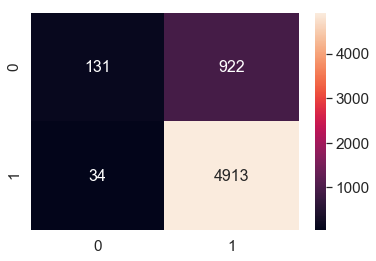

In [29]:
## Accuracy 

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=gsv.best_params_['n_neighbors'])
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print("Accuracy ", (accuracy_score(y_test, y_pred)*100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall on ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))

sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [30]:
%%time 

### KD-Tree Algorithm 


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='kd_tree')

param_grid = {'n_neighbors':np.arange(3,15,2)} #params we need to try on classifier

tscv = TimeSeriesSplit(n_splits=10) #For time based splitting

gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)

print("Best Parameter: ",gsv.best_params_)
print("Best Accuracy ", (gsv.best_score_*100))

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best Parameter:  {'n_neighbors': 7}
Best Accuracy  85.25157232704402
Wall time: 3min 42s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.7min finished


Accuracy  84.06666666666666
Precision  0.8419880034275922
Recall on  0.993127147766323
F1-Score  0.9113337043220183


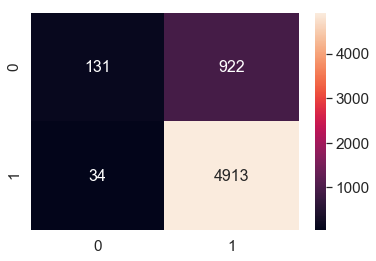

In [31]:
### Accuracy 


from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=gsv.best_params_['n_neighbors'],algorithm='kd_tree')

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print("Accuracy ", (accuracy_score(y_test, y_pred)*100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall on ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))

sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [ ]:
#### Word2Vec, AvgWord2Vec and TfIdfWord2vec pending  (taking Huge time to train)

### Prepare Summary 